# **Load libraries**

In [16]:
import numpy as np 
import pandas as pd 
import joblib
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# **Read and clean data**

In [14]:
from google.colab import files
files.upload()

Saving model_a1_lg.sav to model_a1_lg.sav


{'model_a1_lg.sav': b'\x80\x03ckeras.engine.sequential\nSequential\nq\x00)\x81q\x01}q\x02(X\t\x00\x00\x00_is_groupq\x03\x88X\r\x00\x00\x00keras_versionq\x04C\x052.2.5q\x05X\x07\x00\x00\x00backendq\x06C\ntensorflowq\x07X\x0c\x00\x00\x00model_configq\x08B\xc8\x05\x00\x00{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"class_name": "LSTM", "config": {"name": "lstm_2", "trainable": true, "batch_input_shape": [null, null, 1], "dtype": "float32", "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 5, "activation": "sigmoid", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "

In [ ]:
df = pd.read_csv("BTCUSD_1d_bitstamp.csv",usecols=[0,4])

dates = df['date']
print(df[:5])
#df.drop(['date'], 1, inplace=True)
df['close'].fillna(method='ffill', inplace = True) 
X1, y = df[:len(df)-1], df[1:len(df)]
y.head()

         date  close
0  2011-09-13   5.97
1  2011-09-14   5.53
2  2011-09-15   5.13
3  2011-09-16   4.85
4  2011-09-17   4.87


,date,close
1,2011-09-14,5.53
2,2011-09-15,5.13
3,2011-09-16,4.85
4,2011-09-17,4.87
5,2011-09-18,4.92


In [6]:
df = pd.read_csv("BTCUSD_1d_bitstamp.csv",usecols=[0,4])
print(df[:5])

         date  close
0  2011-09-13   5.97
1  2011-09-14   5.53
2  2011-09-15   5.13
3  2011-09-16   4.85
4  2011-09-17   4.87


In [7]:
#Fill the missing data with last valid observation
dates = df['date']
df.drop(['date'], 1, inplace=True)
df.fillna(method='ffill', inplace = True)   

# **Build Models**

In [23]:
#split train and test set
train_size = 0.8
df_train= df[:round(train_size*len(df))]
df_test= df[round(train_size*len(df)):]
test_set = df_test.values

Baseline: 20-point moving average

In [10]:
#compute baseline MSE
df_baseline = df[round(train_size*len(df))-20:]

window_size = 20
N = df_baseline.size
std_avg_base = []

for pred_idx in range(window_size,N):
    std_avg_base.append(np.mean(df_baseline[pred_idx-window_size:pred_idx]))

MSE_baseline = np.mean((std_avg_base - test_set)**2)
print("Baseline MSE: %s" %MSE_baseline)


Baseline MSE: 622833.0812287888


**1. LSTM**

In [ ]:
#Rescale the train set
train = min_max_scaler.fit_transform(df_train.values)
x_train, y_train = train[:len(train)-1], train[1:len(train)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

#Rescale the test set
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = min_max_scaler.fit_transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

In [21]:
#model training
num_units = 5
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 8
num_epochs = 120

model_1d_2 = Sequential()

model_1d_2.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))
model_1d_2.add(Dense(units = 1))

model_1d_2.compile(optimizer = optimizer, loss = loss_function)

model_1d_2.fit(x_train, y_train, batch_size = batch_size, epochs = num_epochs)

Epoch 1/120
2369/2369 [==============================] - 1s 315us/step - loss: 0.0695
Epoch 2/120
2369/2369 [==============================] - 0s 185us/step - loss: 0.0185
Epoch 3/120
2369/2369 [==============================] - 0s 182us/step - loss: 0.0170
Epoch 4/120
2369/2369 [==============================] - 0s 186us/step - loss: 0.0156
Epoch 5/120
2369/2369 [==============================] - 0s 187us/step - loss: 0.0140
Epoch 6/120
2369/2369 [==============================] - 0s 189us/step - loss: 0.0123
Epoch 7/120
2369/2369 [==============================] - 0s 187us/step - loss: 0.0105
Epoch 8/120
2369/2369 [==============================] - 0s 184us/step - loss: 0.0086
Epoch 9/120
2369/2369 [==============================] - 0s 188us/step - loss: 0.0066
Epoch 10/120
2369/2369 [==============================] - 0s 190us/step - loss: 0.0048
Epoch 11/120
2369/2369 [==============================] - 0s 186us/step - loss: 0.0032
Epoch 12/120
2369/2369 [============================

**Compute MSE of LSTM model**

In [30]:
from sklearn.metrics import mean_squared_error
pred_1d = model_1d_2.predict(inputs)
pred_1d = min_max_scaler.inverse_transform(pred_1d)
MSE_LSTM = mean_squared_error(test_set, pred_1d)
print("LSTM_MSE: %s" %MSE_LSTM)

LSTM_MSE: 3742.3426976911455


In [31]:
#Save the model
import joblib
filename = 'model_1d.sav'
joblib.dump(model_1d_2, filename)

['model_1d.sav']

**Visualize the prediction of LSTM model**

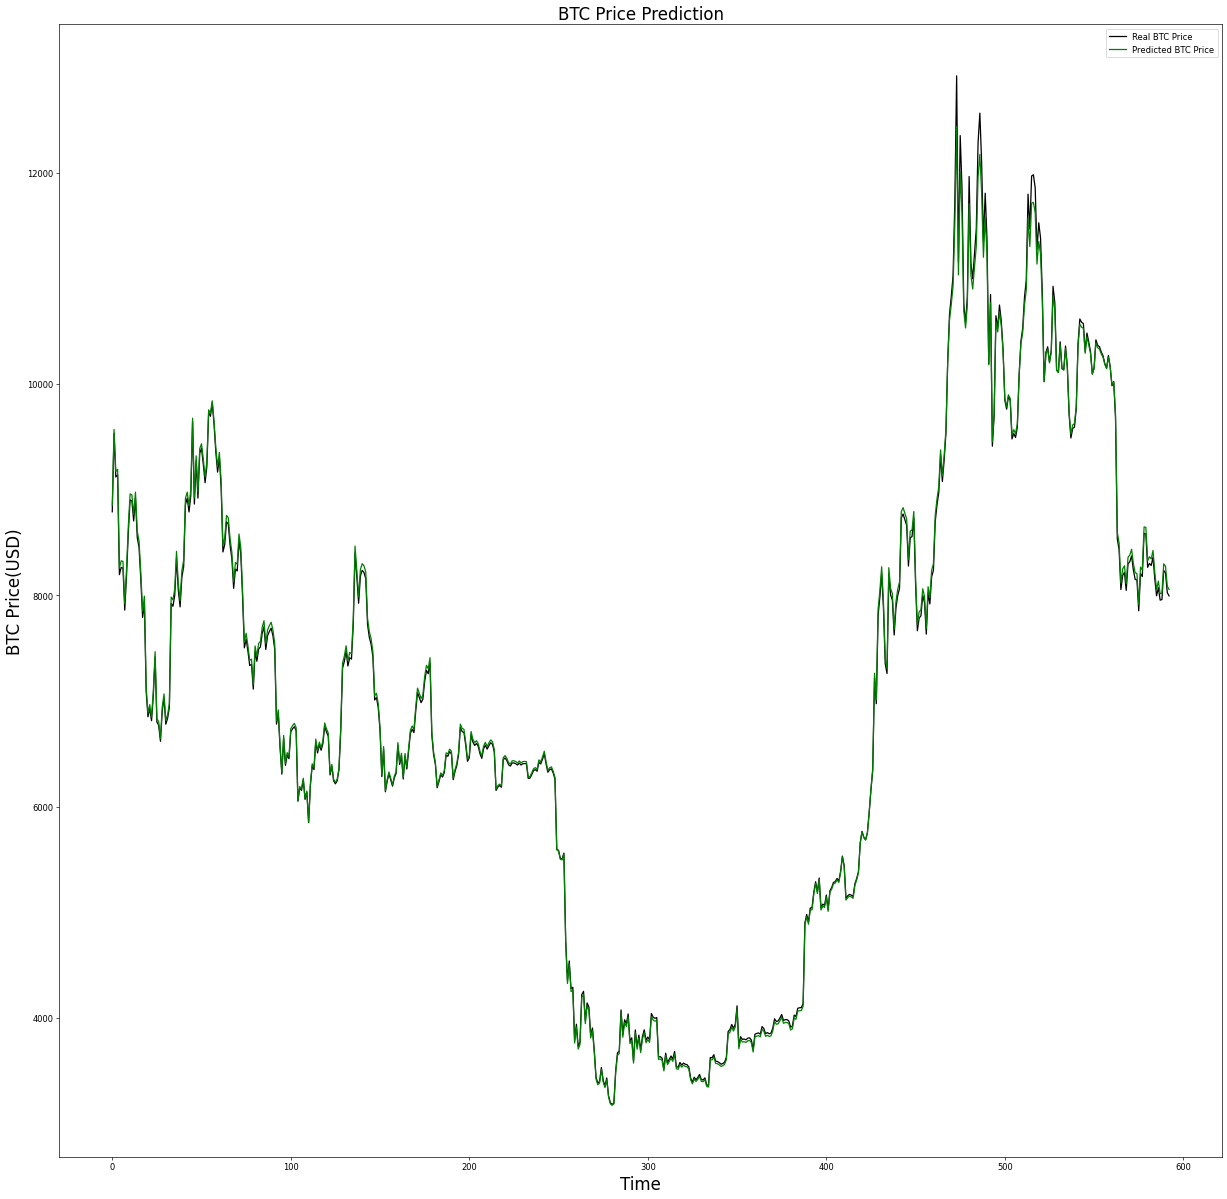

In [25]:
plt.figure(figsize=(25, 25), dpi=60, facecolor = 'w', edgecolor = 'k')

plt.plot(test_set[:, 0], color='black', label='Real BTC Price')
plt.plot(pred_1d[:, 0], color = 'green', label = 'Predicted BTC Price')

plt.title('BTC Price Prediction', fontsize = 20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('BTC Price(USD)', fontsize = 20)
plt.legend(loc = 'best')
plt.show()

**2.ARIMA**

In [39]:
from statsmodels.tsa.arima_model import ARIMA 

model_arima = ARIMA(df_train.values, order=(5,1,0))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2369
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15732.018
Method:                       css-mle   S.D. of innovations            185.269
Date:                Mon, 29 Jun 2020   AIC                          31478.035
Time:                        03:40:39   BIC                          31518.427
Sample:                             1   HQIC                         31492.740
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8268      4.496      0.851      0.395      -4.985      12.639
ar.L1.D.y      0.1114      0.020      5.490      0.000       0.072       0.151
ar.L2.D.y     -0.0498      0.020     -2.449      0.0

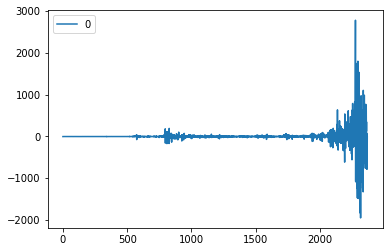

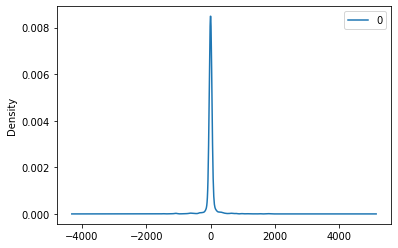

                 0
count  2369.000000
mean     -0.008629
std     185.308361
min   -1950.581486
25%      -6.488170
50%      -3.164542
75%       2.087802
max    2779.471488


In [36]:
# plot residual errors
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

**Forcast with ARIMA Model**

In [73]:
history = [x for x in df_train.values]
arima_predictions = list()
for t in range(len(test_set)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [74]:
arima_predictions[:5]

[array([9272.96307928]),
 array([8815.8380652]),
 array([9716.50608179]),
 array([9097.172649]),
 array([9271.11214813])]

In [75]:
arima_pred = []
for i in arima_predictions:
  arima_pred.append(i.item(0))

**ARIMA model has a much higher MSE than LSTM**

In [76]:
MSE_ARIMA = mean_squared_error(test_set, arima_pred)
print("LSTM_MSE: %s" %MSE_ARIMA)

LSTM_MSE: 92109.3827911214


**Visualize the prediction of ARIMA model**

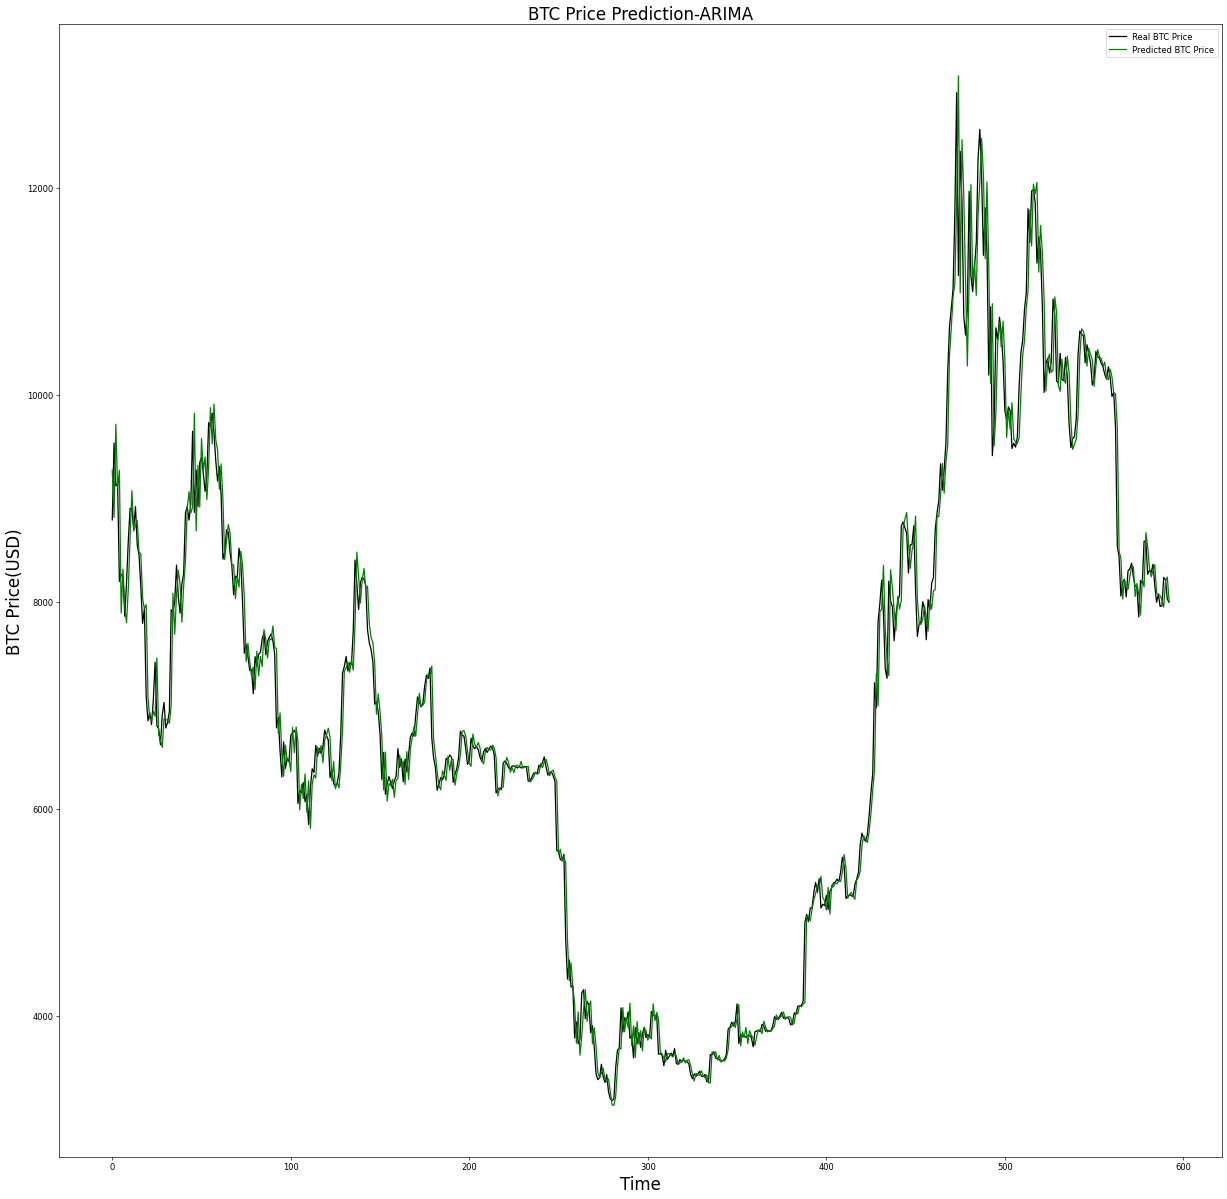

In [78]:
plt.figure(figsize=(25, 25), dpi=60, facecolor = 'w', edgecolor = 'k')

plt.plot(test_set, color='black', label='Real BTC Price')
plt.plot(arima_pred, color = 'green', label = 'Predicted BTC Price')

plt.title('BTC Price Prediction-ARIMA', fontsize = 20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('BTC Price(USD)', fontsize = 20)
plt.legend(loc = 'best')
plt.show()